# End to end example on using model differencing

In this notebook, we demonstrate how to use model differencing to understand the (similarities and) differences between two classifiers trained to do the same classification task. 

For this demo, we choose the [breast-cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) (available in scikit-learn), and two models --- a decision tree of maximum depth of 5, and a gaussian naive bayes classifier from scikit-learn. Note that our method is **model-agnostic**, so the workflow is identical for any two arbitrary model classes.


## Setup

In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from aix360.algorithms.imd.utils import load_bc_dataset

## Data preparation

First we fetch the data using the function `load_bc_dataset()` and split it in train and test splits. The train splits will be used to train two models next, and we can evaluate the model accuracy values on the test split.

Note that, to test the quality of our model differencing technique, we will use this test split `x_test` later on without the ground truth labels `y_test`.

In [3]:
random_state=1234
datadf, target = load_bc_dataset()
x_train, x_test, y_train, y_test = train_test_split(datadf, target, train_size=0.7,
                                                    random_state=random_state)
x_train.shape, x_test.shape

((398, 30), (171, 30))

## Training models

As discussed in the introduction, we fit two models on the training data split.

In [4]:
## model1
model1 = DecisionTreeClassifier(max_depth=5)
model1.fit(x_train, y_train)
print(f"model: {model1}")
tacc = accuracy_score(y_true=y_test, y_pred=model1.predict(x_test))
print(f"model1 test accuracy: {(tacc * 100):.2f}%")



## model2
model2 = GaussianNB()
model2.fit(x_train, y_train)

print(f"model: {model2}")
tacc = accuracy_score(y_true=y_test, y_pred=model2.predict(x_test))
print(f"model2 test accuracy: {(tacc * 100):.2f}%")

model: DecisionTreeClassifier(max_depth=5)
model1 test accuracy: 94.15%
model: GaussianNB()
model2 test accuracy: 88.89%


## Calculate diff-samples %

In the last cell, we observe that the trained models have different test accuracy values on the test split. Now we find out for how many samples the models disagree on their prediction. Typically we observed this value to be $< 10\%$ for most datasets and model pairs.

In this step, we also prepare the necessary inputs to the model differencing step below --- `y1` and `y2` --- which stores the two models' outputs as obtained by invoking their `.predict()` method.

In [5]:
feature_names = x_train.columns.to_list()
x1 = x2 = x_train.to_numpy()
y1 = model1.predict(x1)
y2 = model2.predict(x2)
ydiff = (y1 != y2).astype(int)
print(f"diffs in X_train = {ydiff.sum()} / {len(ydiff)} = {(ydiff.sum()/len(ydiff)):.2f}")

ydifftest = (model1.predict(x_test) != model2.predict(x_test)).astype(int)
print(f"diffs in X_test = {ydifftest.sum()} / {len(ydifftest)} = {(ydifftest.sum()/len(ydifftest)):.2f}")

diffs in X_train = 14 / 398 = 0.04
diffs in X_test = 17 / 171 = 0.10


# Interpretable model differencing

Now we have everything ready (data `x_train`, two outputs `y1` and `y2` from the model pairs) to do interpretable model differencing. The main class implementing the algorithm is `IMDExplainer`. The algorithm requires you to pass a pandas dataframe object `x_train` to internally process the feature names (used in generating diff-rules).

On calling `imd.fit()` the algorithm fits the joint surrogate tree (JST) for the two outputs. The joint surrogate tree is stored in a dictionary format, and can be accessed from the `imd.jst` attribute. Here, we also restrict the maximum depth (a.k.a., height) of the tree to $6$.

In [6]:
from aix360.algorithms.imd.imd import IMDExplainer

In [7]:
max_depth=6

imd = IMDExplainer()
imd.fit(x_train, y1, y2, max_depth=max_depth)

diffs in X_train = 14 / 398 = 3.52%
diverge with e1=-1.4426950249075509e-08, e2=-1.4426950249075509e-08, e=0.3333333140973995
diverge with e1=0.022581030317989238, e2=-1.442695024907551e-08, e=0.03469012205846226


## See diff-rules

Once the algorithm is fitted, the diff-rules can be found in `imd.diffrules` attribute or on calling the `imd.explain()` method.

In [8]:
diffrules = imd.explain()
diffrules

[IF worst area > 960.5000 AND worst perimeter <= 117.4500 AND worst fractal dimension > 0.0812 AND worst concave points <= 0.1348 AND area error <= 49.1450 THEN PREDICT class = 1,
 IF worst fractal dimension <= 0.0619 AND worst perimeter <= 117.4500 AND worst concave points <= 0.1348 AND area error > 49.1450 AND worst area <= 639.1500 THEN PREDICT class = 1,
 IF worst fractal dimension > 0.0619 AND worst perimeter <= 117.4500 AND worst concave points <= 0.1348 AND area error > 49.1450 AND worst area > 639.1500 THEN PREDICT class = 1,
 IF worst perimeter <= 117.4500 AND worst fractal dimension > 0.1046 AND worst concave points > 0.1348 AND worst smoothness <= 0.1785 AND worst texture <= 27.6000 AND compactness error <= 0.0399 THEN PREDICT class = 1,
 IF worst perimeter <= 117.4500 AND worst concave points > 0.1348 AND worst smoothness <= 0.1785 AND worst texture <= 27.6000 AND compactness error > 0.0399 AND worst symmetry > 0.2742 THEN PREDICT class = 1,
 IF worst perimeter <= 117.4500 

## Using the diff-rules

Each rule has an `.apply()` method to filter out data points that satisfy all the predicates present in the rule. The below cell demonstrates and example of finding out the samples satisfying a diff-rule from the training data. For this example, we see 3 samples that satisfy this particular rule.

In [9]:
rule_idx = 4

rule = diffrules[rule_idx]
filtered_data = x_train[rule.apply(x_train)]
filtered_data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
89,14.640,15.24,95.77,651.9,0.11320,0.1339,0.09966,0.07064,0.2116,0.06346,...,16.34,18.24,109.4,803.6,0.1277,0.3089,0.2604,0.1397,0.3151,0.08473
68,9.029,17.33,58.79,250.5,0.10660,0.1413,0.31300,0.04375,0.2111,0.08046,...,10.31,22.65,65.5,324.7,0.1482,0.4365,1.2520,0.1750,0.4228,0.11750
465,13.240,20.13,86.87,542.9,0.08284,0.1223,0.10100,0.02833,0.1601,0.06432,...,15.44,25.50,115.0,733.5,0.1201,0.5646,0.6556,0.1357,0.2845,0.12490


In [10]:
# see the model predictions on the filtered samples --- they should mostly be different
model1.predict(filtered_data), model2.predict(filtered_data)

(array([1, 1, 1]), array([0, 0, 0]))

## Computation of metrics

We discussed to use precision, recall, and interpretability metrics to evaluate the quality of model differencing. The metrics can be computed in one go by invoking the `.metrics()` method with data and outputs from the two models as shown below.

In [11]:
# on train set
imd.metrics(x_train, y1, y2, name="train")

{'diffs': 14,
 'samples': 398,
 'train-precision': 1.0,
 'train-recall': 1.0,
 'num-rules': 9,
 'num-unique-preds': 26}

In [12]:
# on test set
imd.metrics(x_test, model1.predict(x_test), model2.predict(x_test), name="test")

{'diffs': 17,
 'samples': 171,
 'test-precision': 0.333333,
 'test-recall': 0.058824,
 'num-rules': 9,
 'num-unique-preds': 26}

## Generate the jst visualization
To generate the JST visualisation as described in the UAI paper, do the following:

In [13]:
from aix360.algorithms.imd.utils import visualize_jst
from IPython.display import display, Image

Note that (one or more) diff-rules are grouped under the dotted or nodes. For example, the node `vo0` has only 1 diffrule that has the following predicates: `worst perimeter <= 117.4500` --> `worst concave points <= 0.1348` --> `area error <= 49.1450` (hits the or node `vo0`, surrogate (2) is pure with only one cyan colored leaf) --> `worst area > 960.5000` --> `worst fractal dimension > 0.0812` (brings to the beige colored pure leaf node for surrogate (1) which disagrees with the cyan colored leaf node of surrogate (2) as grouped under `vo0`).

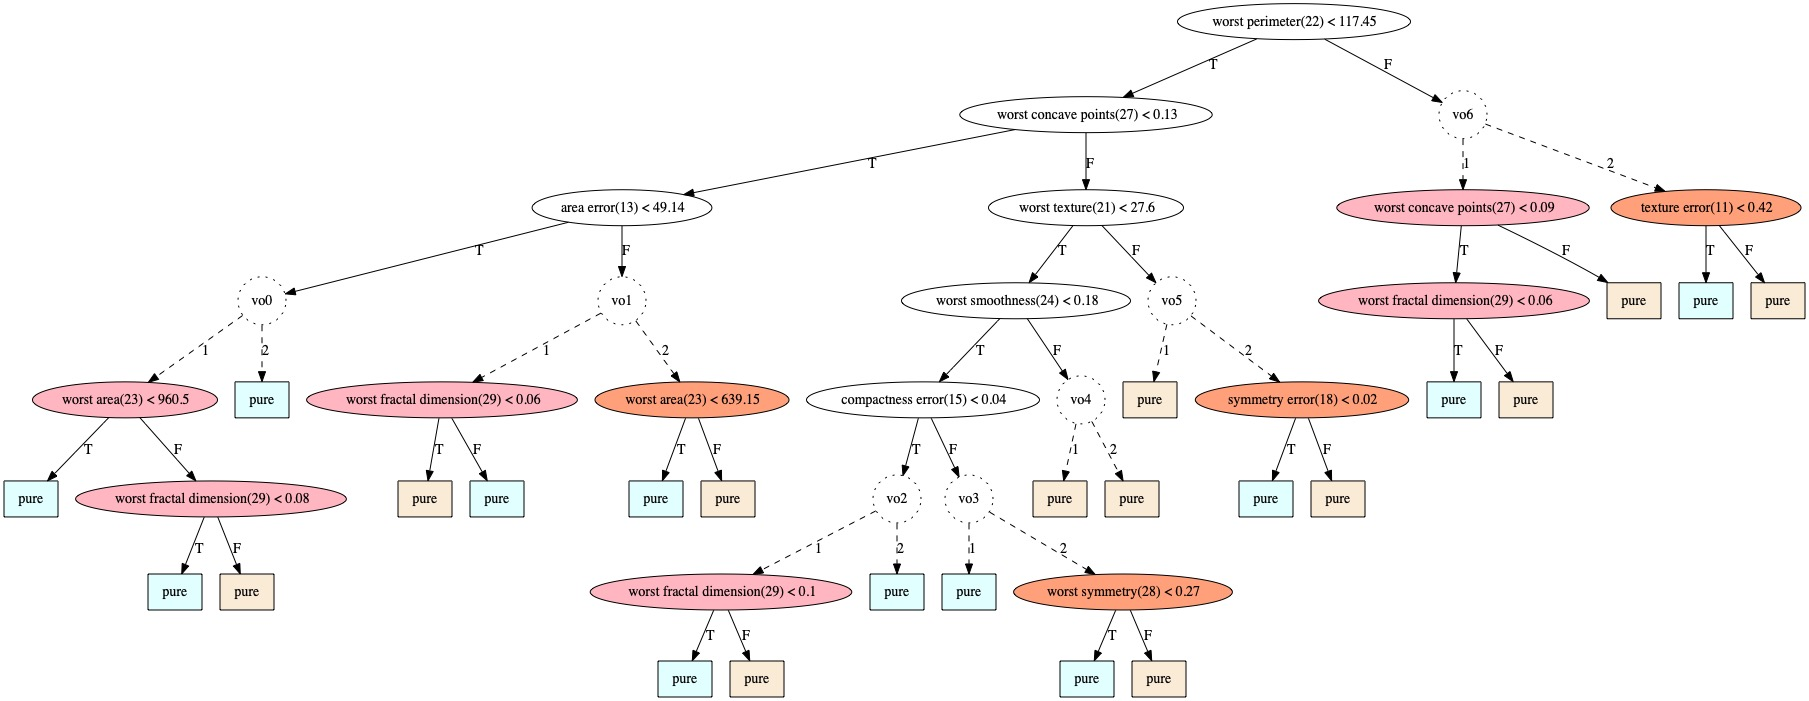

In [14]:
display(Image(visualize_jst(imd.jst, path="joint.jpg"), width=2000, unconfined=True))

# Separate surrogate approach 

In our paper, we discussed the separate surrogates approach as another baseline where we simply build two decision tree surrogates and intersect their disagreeing leaves to get the diff-rules. This can be implemented as follows by passing `split_criterion=2` and `alpha=1.0` parameters during fitting an `IMDExplainer()` object.

Note the improvement in precision and recall, but it comes with a huge increase in number of rules, as also evident from the visualization below.

In [15]:
sepsur = IMDExplainer()
sepsur.fit(x_train, y1, y2, max_depth=max_depth, split_criterion=2, alpha=1.0)

diffs in X_train = 14 / 398 = 3.52%
diverge with e1=0.3086851675144673, e2=0.269802596591297, e=0.3025354309939994


In [16]:
# on train set
sepsur.metrics(x_train, y1, y2, name="train")

{'diffs': 14,
 'samples': 398,
 'train-precision': 1.0,
 'train-recall': 1.0,
 'num-rules': 43,
 'num-unique-preds': 36}

In [17]:
# on test set
sepsur.metrics(x_test, model1.predict(x_test), model2.predict(x_test), name="test")

{'diffs': 17,
 'samples': 171,
 'test-precision': 0.7,
 'test-recall': 0.411765,
 'num-rules': 43,
 'num-unique-preds': 36}

## Visualizing separate surrogates

Note that the jst from separate surrogate approach below has one diverging node at the top, and the surrogates do not share any common split node.

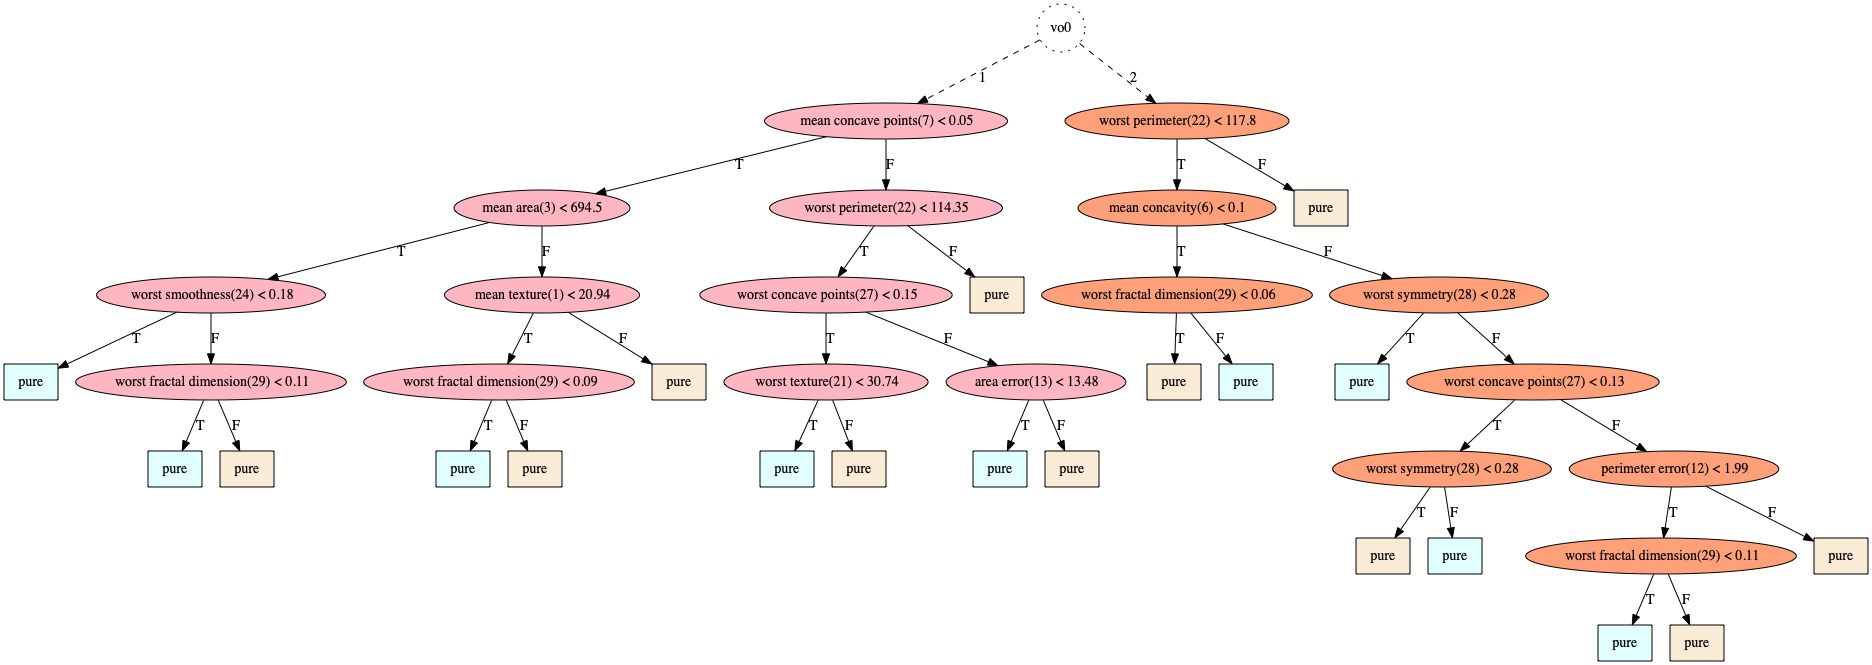

In [18]:
display(Image(visualize_jst(sepsur.jst, path="separate.jpg"), width=2500, unconfined=True))